In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

pd.set_option('max_colwidth', 1200)

In [ ]:
torch.__version__

'1.13.1+cu116'

In [ ]:
!pip install -q kaggle
!pip install transformers
!pip install wandb -qU
!pip install -U torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d virajbagal/roco-dataset
!unzip roco-dataset.zip

## Create image captioning dataset

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.8 MB/s eta 0:00:00


### Train Dataset

In [ ]:
captions_train = pd.read_csv("all_data/train/radiologytraindata.csv")
# captions_train = pd.read_csv("all_data/train/radiology/captions.txt", on_bad_lines='skip', sep="\t", names=["id", "caption"])

In [ ]:
captions_train.head()

,id,name,caption
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showing obliteration of the left maxillary sinus\n
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,"Bacterial contamination occurred after completion of root canal treatment in the tooth, which remained with a temporary filling for 15 month.\n"
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the hand after poliomyelitis. It was necessary to stabilize the thumb with reference to the index finger. This was accomplished by placing a graft from the bone bank between the first and second metacarpals. The roentgenogram shows the complete healing of the graft one year later.\n
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,"Plain abdomen x-ray: Multiple air levels at the mid-abdomen (arrows), no radiopaque shadow, and no air under the diaphragm.\n"


In [ ]:
keywords_train = pd.read_csv("all_data/train/radiology/keywords.txt", on_bad_lines='skip', sep="\t\t", names=["id", "keywords"])
keywords_train.head()

,id,keywords
0,ROCO_00002,scan\tmaxillary\tsinu\taxial\ttomography\tobliteration\tview\tleft
1,ROCO_00003,canal\tcompletion\ttemporary\tmonth\tfilling\ttreatment\tcontamination\tbacterial\ttooth\troot
2,ROCO_00004,poliomyeliti\tindex\thealing\tnecessary\tcomplete\treference\tresidual\troentgenogram\thand\tmetacarpal\tsecond\tparalysi\tfinger\tyear\tthumb\tpatient\tgraft\tbank\tbone\tfirst
3,ROCO_00005,panoramic\tloading\timmediate\tradiograph
4,ROCO_00007,multiple\tradiopaque\tlevel\tdiaphragm\tplain\tair\tabdoman\tshadow\tmidabdoman


In [ ]:
df = pd.merge(captions_train, keywords_train, on="id")
len(df)

65450

In [ ]:
chest_x_ray_captions_train = df[df.caption.str.contains("chest x-ray", case=False, na=False)]
chest_x_ray_captions_train = chest_x_ray_captions_train.drop("id", axis=1)

chest_x_ray_captions_train.rename(columns = {'name':'file_name', 'caption':'text', 'keywords': 'vocab'}, inplace = True)
len(chest_x_ray_captions_train)

1735

In [ ]:
# chest_x_ray_captions_train.to_csv('all_data/train/metadata.csv', index=False, encoding='utf-8')

In [ ]:
metadata_df = chest_x_ray_captions_train.copy()
captions = []
for index, row in chest_x_ray_captions_train.iterrows():
  captions.append({"file_name": row["file_name"], "text": row["text"], "vocab": row["vocab"].replace("\t", " ")})

In [ ]:
captions[0]

{'file_name': 'PMC5144533_IJCCM-20-677-g002.jpg',
 'text': ' Chest X-ray, which confirmed the position of guidewire, extending from the right internal jugular vein up to inferior vena cava\n',
 'vocab': 'right guidewire jugular xray chest internal vena position'}

In [ ]:
#captions["vocab"]
vocabs = []
for caption in captions:
  vocabs.append(caption['vocab'])

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

examples = [
    "The quick mention is: what da, what!",
    "Hey! what are you doning men?"
]

def yield_tokens():
  for vocab in vocabs:
    tokens = tokenizer(vocab)
    yield tokens

In [ ]:
token_generator = yield_tokens()
vocab = build_vocab_from_iterator(token_generator)

In [ ]:
vocab.get_stoi()

{'yellow': 1917,
 'xraylateral': 1914,
 'xraydense': 1913,
 'xraychest': 1912,
 'worsening': 1909,
 'wireiabp': 1906,
 'wg': 1904,
 'wellcircumscribed': 1903,
 'water': 1901,
 'ward': 1900,
 'voltage': 1898,
 'vocal': 1897,
 'visualisation': 1896,
 'viscu': 1895,
 'viscera': 1894,
 'victim': 1891,
 'venovenou': 1888,
 'venoveno': 1887,
 'venoarterial': 1886,
 'vasculture': 1882,
 'vascularization': 1880,
 'v': 1876,
 'ushaped': 1874,
 'urgent': 1872,
 'uneventful': 1868,
 'undersurface': 1867,
 'undergone': 1866,
 'unclear': 1865,
 'umbilical': 1863,
 'ul': 1862,
 'uip': 1861,
 'twothird': 1858,
 'twenty': 1856,
 'tuberculotic': 1852,
 'trocar': 1850,
 'tripleluman': 1849,
 'tricuspid': 1848,
 'tree': 1846,
 'transthoracic': 1845,
 'transplant': 1843,
 'transparency': 1842,
 'transfer': 1841,
 'tram': 1839,
 'tracheotomy': 1836,
 'trabeculation': 1834,
 'tothe': 1832,
 'top': 1831,
 'titre': 1828,
 'tiedown': 1827,
 'thyroid': 1826,
 'thrombotic': 1824,
 'thrombolysi': 1823,
 'thread':

In [ ]:
import json

# path to the folder containing the images
root = "/content/all_data/train/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

In [ ]:
# Copy train images under the train folder

import shutil

for index, row in chest_x_ray_captions_train.iterrows():
  colab_link = "/content/all_data/train/radiology/images/" + row['file_name']
  gdrive_link = "/content/all_data/train"
  shutil.copy(colab_link, gdrive_link)


### Test Dataset

In [ ]:
captions_test = pd.read_csv("all_data/test/radiologytestdata.csv")
keywords_test = pd.read_csv("all_data/test/radiology/keywords.txt", on_bad_lines='skip', sep="\t\t", names=["id", "keywords"])
df_test = pd.merge(captions_test, keywords_test, on="id")
df_test.head()

In [ ]:
chest_x_ray_captions_test = df_test[df_test.caption.str.contains("chest x-ray", case=False, na=False)]
chest_x_ray_captions_test = chest_x_ray_captions_test.drop("id", axis=1)

chest_x_ray_captions_test.rename(columns = {'name':'file_name', 'caption':'text', 'keywords': 'vocab'}, inplace = True)
len(chest_x_ray_captions_test)

199

In [ ]:
metadata_test_df = chest_x_ray_captions_test.copy()
captions_test = []
for index, row in metadata_test_df.iterrows():
  captions_test.append({"file_name": row["file_name"], "text": row["text"], "vocab": row["vocab"].replace("\t", " ")})

In [ ]:
#captions["vocab"]
vocabs = []
for caption in captions_test:
  vocabs.append(caption['vocab'])

In [ ]:
import json

# path to the folder containing the images
root = "/content/all_data/test/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions_test:
        f.write(json.dumps(item) + "\n")

In [ ]:
# Copy test images under the test folder

import shutil

for index, row in chest_x_ray_captions_test.iterrows():
  colab_link = "/content/all_data/test/radiology/images/" + row['file_name']
  gdrive_link = "/content/all_data/test"
  shutil.copy(colab_link, gdrive_link)

### Validation Dataset

In [ ]:
captions_val = pd.read_csv("all_data/validation/radiologyvaldata.csv")
keywords_val = pd.read_csv("all_data/validation/radiology/keywords.txt", on_bad_lines='skip', sep="\t\t", names=["id", "keywords"])
df_val = pd.merge(captions_val, keywords_val, on="id")
df_val.head()

,id,name,caption,keywords
0,ROCO_00020,PMC3970251_CRIONM2014-931546.003.jpg,"Axial computed tomography scan of the pelvis showing a diffuse infiltration of the bladder wall, catheter in situ (arrow).\n",pelvi\tscan\twall\tbladder\tsitu\taxial\tarrow\tinfiltration\ttomography\tcatheter\tdiffuse
1,ROCO_00027,PMC2766744_cios-1-176-g005.jpg,Postoperative anteroposterior radiograph of the pelvis.\n,postoperative\tpelvi\tradiograph\tanteroposterior
2,ROCO_00059,PMC3789931_poljradiol-78-3-35-g001.jpg,"Angiography of the internal carotid artery, late arterial phase. (A) – venous drainage of the AVM, (B) – main arterial supplying vessel, arrow – AVM nidus.\n",arterial\tangiography\tnidu\tvenou\tdrainage\tlate\tavm\tinternal\tarrow\tcarotid\tphase\tartery\tmain\tvessel
3,ROCO_00062,PMC2676075_p147_fig4a.jpg,Case 4: (A) pretreatment radiograph; (B) Root-canal filled showing one canal with a lot of foraminas around the apical area.\n,canal\tcase\tapical\trootcanal\tforamina\tpretreatment\tarea\tradiograph\tlot
4,ROCO_00068,PMC5292123_CRIGM2017-1710501.002.jpg,Preintervention MRCP revealing a nine-millimeter stone in the cystic duct (marked with arrow).\n,mrcp\tstone\tninemillimeter\tpreintervention\tduct\tarrow\tcystic


In [ ]:

chest_x_ray_captions_val = df_val[df_val.caption.str.contains("chest x-ray", case=False, na=False)]
chest_x_ray_captions_val = chest_x_ray_captions_val.drop("id", axis=1)

chest_x_ray_captions_val.rename(columns = {'name':'file_name', 'caption':'text', 'keywords': 'vocab'}, inplace = True)
len(chest_x_ray_captions_val)

222

In [ ]:
metadata_val_df = chest_x_ray_captions_val.copy()
captions_val = []
for index, row in metadata_val_df.iterrows():
  captions_val.append({"file_name": row["file_name"], "text": row["text"], "vocab": row["vocab"].replace("\t", " ")})

In [ ]:
import json

# path to the folder containing the images
root = "/content/all_data/validation/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions_val:
        f.write(json.dumps(item) + "\n")

In [ ]:
# Copy validation images under the validation folder

import shutil

for index, row in chest_x_ray_captions_val.iterrows():
  colab_link = "/content/all_data/validation/radiology/images/" + row['file_name']
  gdrive_link = "/content/all_data/validation"
  shutil.copy(colab_link, gdrive_link)

In [ ]:
!rm -rf "/content/all_data/train/non-radiology/"
!rm -rf "/content/all_data/train/radiology/"

!rm -rf "/content/all_data/test/non-radiology/"
!rm -rf "/content/all_data/test/radiology/"

!rm -rf "/content/all_data/validation/non-radiology/"
!rm -rf "/content/all_data/validation/radiology/"

In [ ]:
from datasets import load_dataset 
root = "all_data/"
train_dataset = load_dataset("imagefolder", data_dir=root, split="train")
val_dataset = load_dataset("imagefolder", data_dir=root, split="validation")
test_dataset = load_dataset("imagefolder", data_dir=root, split="test")

Resolving data files:   0%|          | 0/1737 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/201 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/224 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-51644c2e44f22ec5/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Resolving data files:   0%|          | 0/1737 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/201 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/224 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1737 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/201 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/224 [00:00<?, ?it/s]

In [ ]:
train_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 1735
})

bilateral admission xray chest lung infiltration girl film


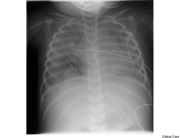

In [ ]:
example = train_dataset[0]
image = example["image"]
print(example['vocab'])
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

## Create PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor, annotations_file, vocab):
        self.dataset = dataset
        self.processor = processor
        self.vocab = vocab
        self.transform = transforms.Compose([ 
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        caption = item.caption
        tokens = str(caption).lower().split()
        target = []
        target.append(vocab.stoi['<start>'])
        target.extend([vocab.stoi[token] for token in tokens])
        target.append(vocab.stoi['<end>'])
        target = torch.Tensor(target).long()


        encoding = self.processor(images=item["image"], text=item["text"], label=label, padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

## Load model and processor

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
loss = torch.nn.BCELoss(size_average=True)

criterion = torch.nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else torch.nn.CrossEntropyLoss()

In [ ]:
import requests
# from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco").to("cuda")

In [ ]:
processor

GitProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "GitProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: BertTokenizerFast(name_or_path='microsoft/git-base-coco', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
train_dataset = ImageCaptioningDataset(train_dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

val_dataset = ImageCaptioningDataset(val_dataset, processor)
val_dataloader = DataLoader(val_dataset, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

KeyError: ignored

## Dummy forward pass

In [ ]:
def train(model, device, train_dataloader, optimizer, epoch):
  train_loss=[]
  train_accuracy=[]
  test_accuracy=[]

  progress_bar = tqdm(range(num_training_steps))

  model.train()
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    attention_mask = batch.pop("attention_mask").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    print(outputs.loss, outputs.logits.shape)
  
    loss = outputs.loss
    loss.backward()
    train_loss.append(loss.item())

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)  

In [ ]:
from datasets import load_metric

def evaluate(model, device, eval_dataloader):
  metric = load_metric("glue", "mrpc")
  model.eval()
  #for batch in eval_dataloader:
  for idx, batch in enumerate(eval_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    attention_mask = batch.pop("attention_mask").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    print("dir(batch)")
    print(dir(batch))

    """
    batch = {k: v.to(device) for k, v in batch.items()}
    print(batch)
    """
    with torch.no_grad():
      outputs = model(input_ids=input_ids,
                pixel_values=pixel_values,
                labels=input_ids)
      #outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).flatten()

    print("pixel_values.shape")
    print(pixel_values.shape)

    print("input_ids.shape")
    print(input_ids.shape)

    print("predictions.shape")
    print(predictions.shape)

    metric.add_batch(predictions=predictions, references=input_ids)
  metric.compute()

In [ ]:
from torch.optim import lr_scheduler
from transformers import get_scheduler
from tqdm.auto import tqdm
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)



for epoch in range(num_epochs):
  train(model, device, train_dataloader, optimizer, epoch)
  #evaluate(model, device, val_dataloader)

## Inference

In [ ]:
# load image
example = train_dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

## Fine-tuning in PyTorch with the Trainer API

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, input_ids = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=input_ids)

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    "test_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01
)

trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1735
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 545
  Number of trainable parameters = 176619066
vision_config is None. initializing the GitVisionConfig with default values.
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


ValueError: ignored

In [ ]:
model_save_name = 'microsoft_git_image_captioning.pt'
path = f"/content/gdrive/MyDrive/NioyatechTask/models/{model_save_name}"
model.save_pretrained(path) 
  #torch.save(model.state_dict(), path)
  #load_state_dict(torch.load(path))

In [ ]:
"""
model.train()
total_loss = 0

for epoch in range(num_epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss
    # total_loss += loss

    print("Loss:", loss.item())
    # print("Total Loss:", total_loss)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    if idx:
        wandb.log({"loss": loss})

# torch.save(model.state_dict(), "/content/all_data/models")
"""

In [ ]:
#training_args = TrainingArguments("test-trainer")

In [ ]:
"""
trainer = Trainer(
    model,
    training_args,
    train_dataset=dataset,
    eval_dataset=dataset_validation
)
"""

In [ ]:
"""
def evaluate(model, device, test_dataloader):
  loss = 0
  success = 0

  num_correct = 0
  num_samples = 0
  total_loss = 0

  losstensorMean = 0


  # Tracking variables
  val_accuracy = []
  val_loss = []
  f1_weighted = []

  result = []
  model.eval()
  with torch.no_grad():
    for batch in test_dataloader:

      # input_ids, pixel_values = input_ids.to(device), pixel_values.to(device)
      input_ids = batch.pop("input_ids").to(device)
      # batch.pop("input_ids").type(torch.FloatTensor).to(device)
      pixel_values = batch.pop("pixel_values").to(device)

      ""
      captions = model.generate(pixel_values, num_beams=3, 
                                max_length=20, 
                                min_length=5)
        
      for caption, img_id in zip(captions, input_ids):
          result.append({"image_id": img_id.item(), "caption": caption})
      ""

      #outputs = model(input_ids=input_ids,
      #     pixel_values=pixel_values,
      #     labels=input_ids)

      pred_prob = model(input_ids=input_ids, attention_mask=batch["attention_mask"])
      
      #print("pred_prob.logits")
      #print(pred_prob.logits.shape)
      #print("pred_prob[0]")
      #print(pred_prob[0].shape)

      itm_score = torch.nn.functional.softmax(pred_prob.logits, dim=1)[:, 1]
      print("itm_score")
      print(itm_score)

      loss += F.nll_loss(pred_prob[:,1], input_ids, reduction='sum').item() # loss summed across the batch
      print("loss")
      print(loss)

      ""
      # loss = criterion(pred_prob.logits, batch.view(1, -1))
      print("loss")
      print(pred_prob.logits.shape)
      print(pred_prob[0].shape)
      print("input_ids.shape")
      print(input_ids.shape)

      predictions = torch.argmax(pred_prob[0], dim=2)
      print("predictions")
      print(predictions)
      print("predictions.shape")
      print(predictions.shape)
      ""
      #correct_predictions = sum(predictions==input_ids).item()
      #print("correct_predictions")
      #print(correct_predictions)

      #losstensor = loss(pred_prob.logits, input_ids)
      #print("losstensor")
      #print(losstensor)
      
      # logits = outputs[0]

      # print(logits)

      ## val_loss.append(outputs.loss.item())

      # Calculate the accuracy rate
      #accuracy = (predictions == input_ids).cpu().numpy().mean() * 100
      #print(accuracy)
      #val_accuracy.append(accuracy)


      #print(val_accuracy)

      # print(type(pixel_values))

      #losstensor = loss(pred_prob.logits, input_ids)
      #print(losstensor)
      # losstensorMean += losstensor
        
      # lossVal += losstensor.item()
      # lossValNorm += 1

      #total_loss += outputs.loss.item()
    #print("Total loss", total_loss)

    # outLoss = lossVal / lossValNorm
    # losstensorMean = losstensorMean / lossValNorm

    # return outLoss, losstensorMean
      
      #itm_score = torch.nn.functional.softmax(pred_prob, dim=1)[:, 1]
      
      #print(itm_score)

      #_, predictions = pred_prob.max(1)
      #num_correct += (itm_score == input_ids).sum()
      #num_samples += itm_score.size(0)

    #print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
      
      # loss = pred_prob.loss
      # pred_prob = model(input_ids)

      # loss += F.nll_loss(pred_prob, pixel_values, reduction='sum').item() # loss summed across the batch
      
      # logits_per_image = pred_prob.logits_per_image
      # probs = logits_per_image.softmax(dim=1)
  

      # pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
      # success += pred.eq(pixel_values.view_as(pred)).sum().item()
  # loss /= len(test_dataloader.dataset)
  # print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
  #    loss, success, len(test_dataloader.dataset),
  #    100. * success / len(test_dataloader.dataset)))


"""

In [ ]:
    """

    #model.eval()
    with torch.no_grad():
      check_accuracy(val_dataloader, model)
      #for val_image, val_label in val_dataloader:
      #  evaluate(model, val_dataloader)

      #print("pixel_values.shape")
      #print(pixel_values.shape)
      #output_test = model(pixel_values)
      #test_accuracy.append(get_accuracy(outputs, input_ids))

    if (epoch + 1) % 5 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Train Accuracy: {sum(train_accuracy)/len(train_accuracy):.2f}")
    ""
          print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, 
          Train Accuracy: {sum(train_accuracy)/len(train_accuracy):.2f}, 
          Test Accuracy: {sum(test_accuracy)/len(test_accuracy):.2f}")
    if idx % 10 == 0:
      wandb.log({"loss": loss})
      print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
          epoch, idx * len(input_ids), 
          len(train_dataloader.dataset),
          100. * idx / len(train_dataloader), 
          loss.item()))
    ""
  return train_loss, train_accuracy
  """

'\n\n#model.eval()\nwith torch.no_grad():\n  check_accuracy(val_dataloader, model)\n  #for val_image, val_label in val_dataloader:\n  #  evaluate(model, val_dataloader)\n\n  #print("pixel_values.shape")\n  #print(pixel_values.shape)\n  #output_test = model(pixel_values)\n  #test_accuracy.append(get_accuracy(outputs, input_ids))\n\nif (epoch + 1) % 5 == 0:\n  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Train Accuracy: {sum(train_accuracy)/len(train_accuracy):.2f}")\n""\n      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, \n      Train Accuracy: {sum(train_accuracy)/len(train_accuracy):.2f}, \n      Test Accuracy: {sum(test_accuracy)/len(test_accuracy):.2f}")\nif idx % 10 == 0:\n  wandb.log({"loss": loss})\n  print(\'epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}\'.format(\n      epoch, idx * len(input_ids), \n      len(train_dataloader.dataset),\n      100. * idx / len(train_dataloader), \n      loss.item()))\n""\n  return train_loss,

In [ ]:
"""
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    ""
    print({k: v.shape for k, v in batch.items()})
    {
      'input_ids': torch.Size([2, 512]), 
      'attention_mask': torch.Size([2, 512]), 
      'pixel_values': torch.Size([2, 3, 224, 224])
    }

    print({k: v.shape for k, v in batch2.items()})
    {'input_ids': torch.Size([2, 512]), 
    'attention_mask': torch.Size([2, 512]), 
    'pixel_values': torch.Size([2, 3, 224, 224])
    }
    for idx, batch in enumerate(train_dataloader):


    
    with torch.no_grad():
      for batch in loader: 

        #input_ids = batch.pop("input_ids").to(device)
        #pixel_values = batch.pop("pixel_values").to(device)
        #attention_mask = batch.pop("attention_mask").to(device)

        #scores = model(input_ids=input_ids, 
        #                attention_mask=attention_mask)

        batch = {k: v.to(device) for k, v in batch.items()}
        scores = model(**batch)

        predictions = torch.argmax(scores.logits)

        print("scores.logits.shape")
        print(scores.logits.shape)

        print("predictions")
        print(predictions)

        print("input_ids")
        print(input_ids)

        num_correct += (predictions == input_ids).sum()
        num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

      model.train()
  """"
